# HNSW
- The top layer is sparse and becomes denser as we go deeper

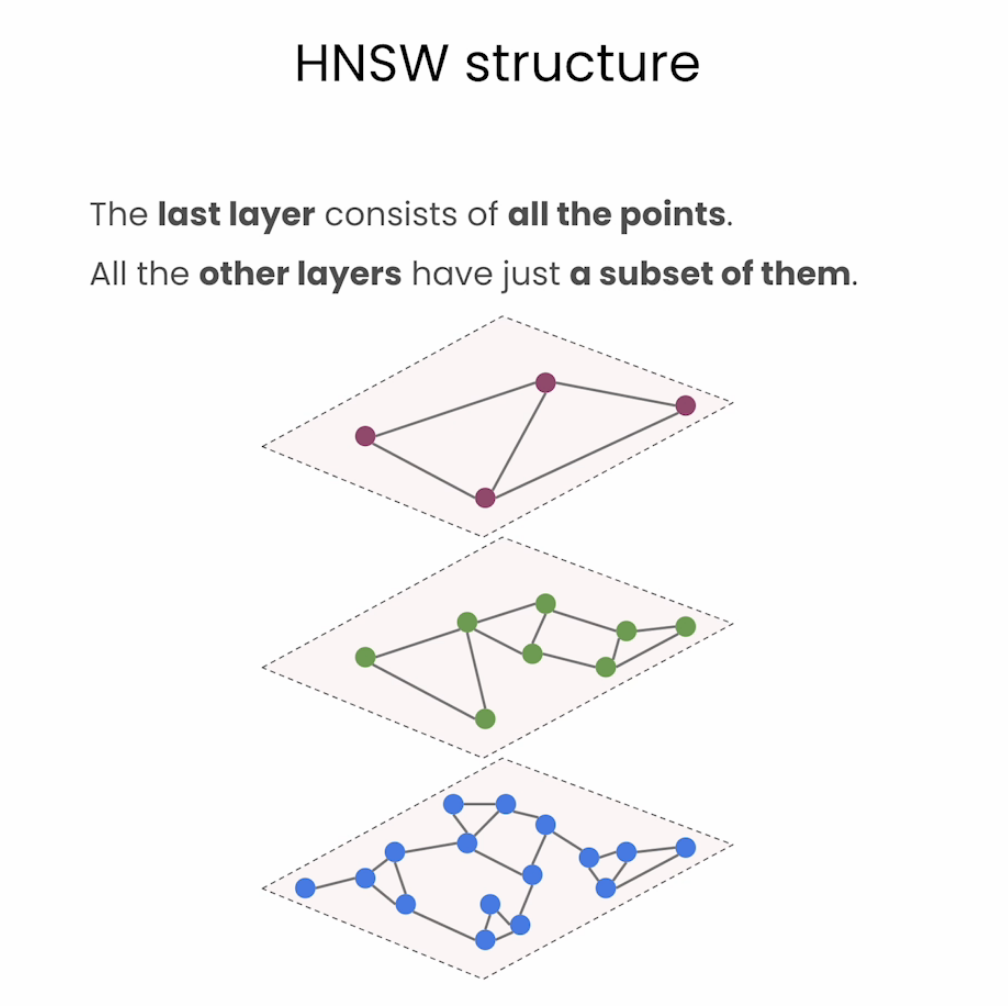
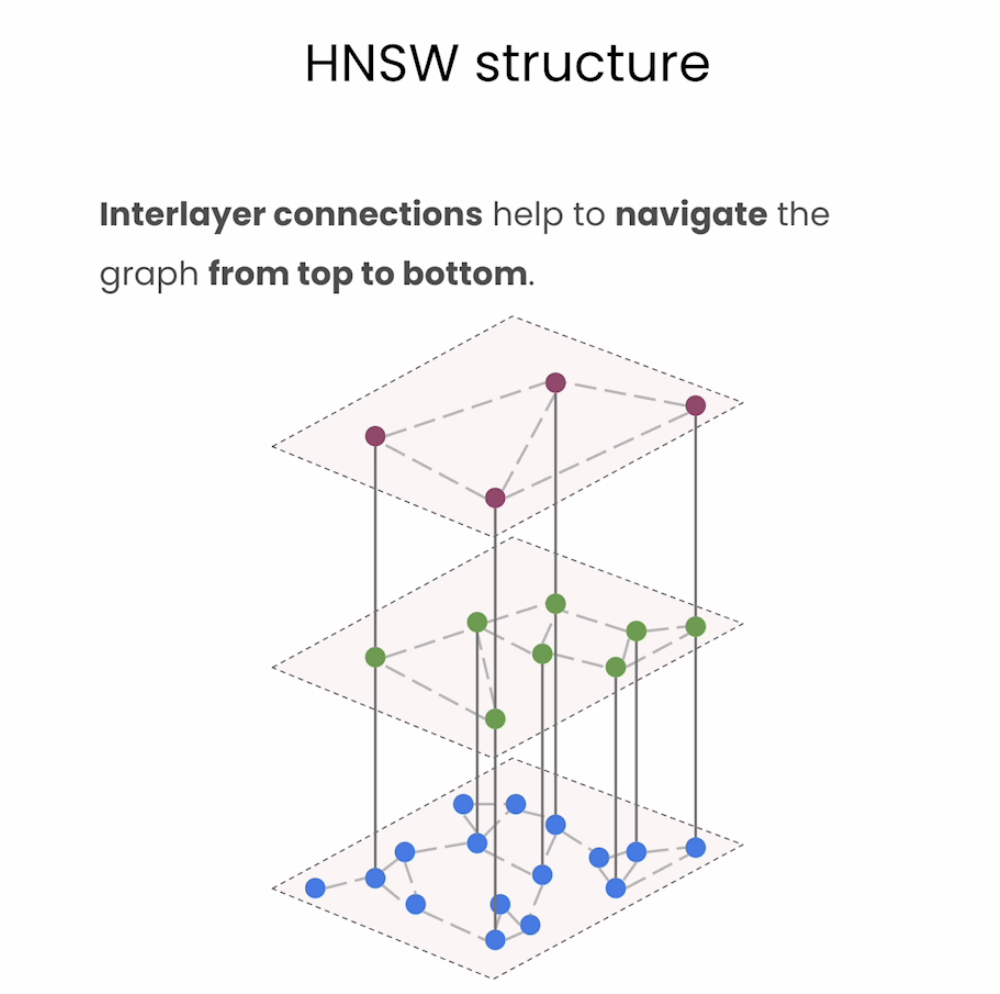
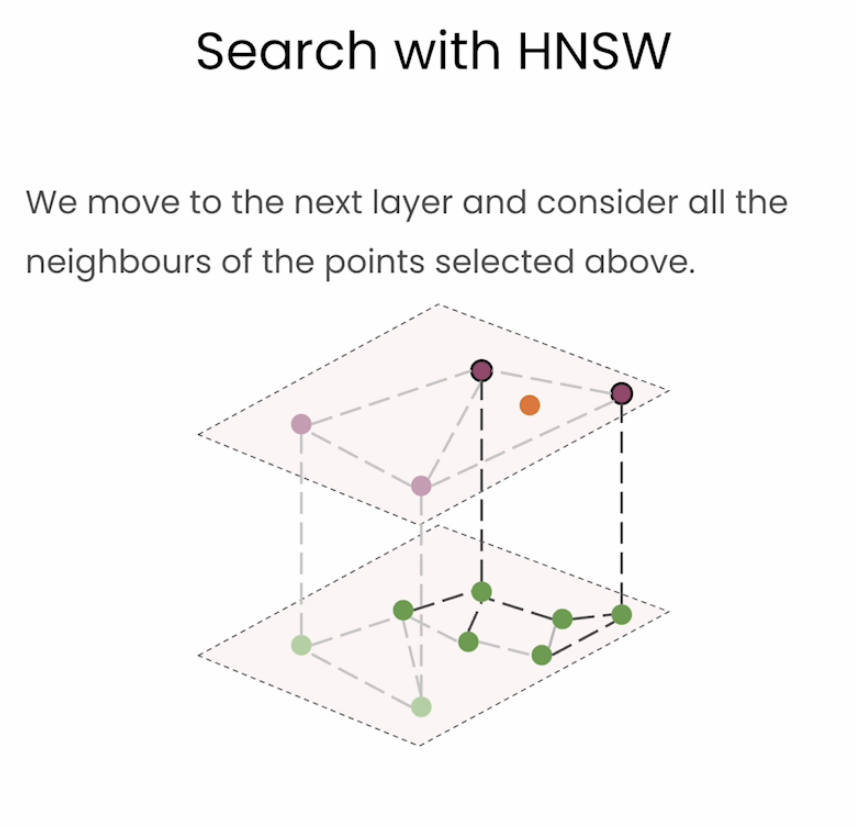
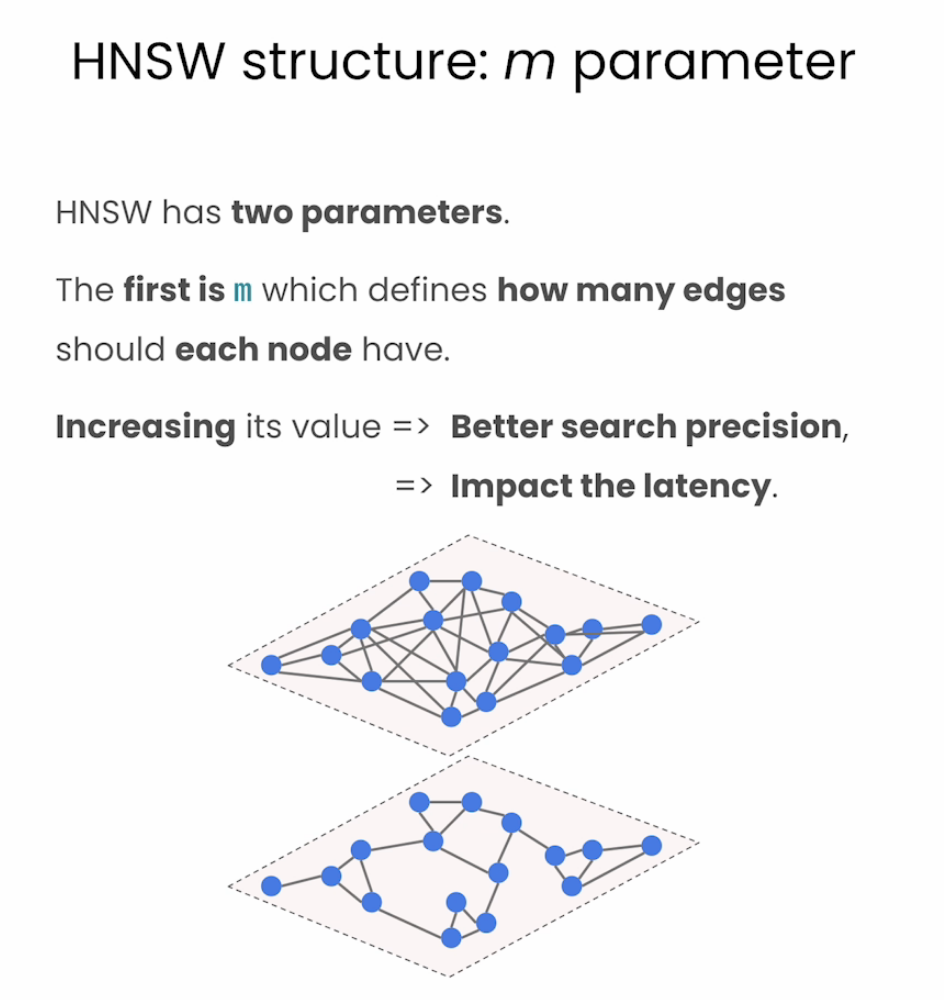
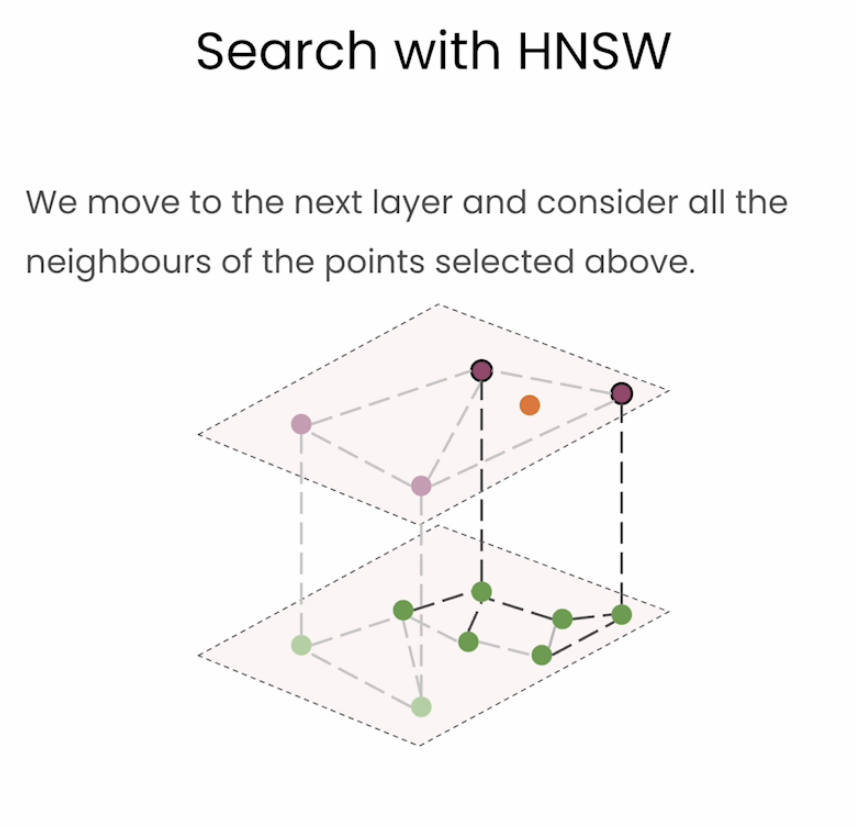
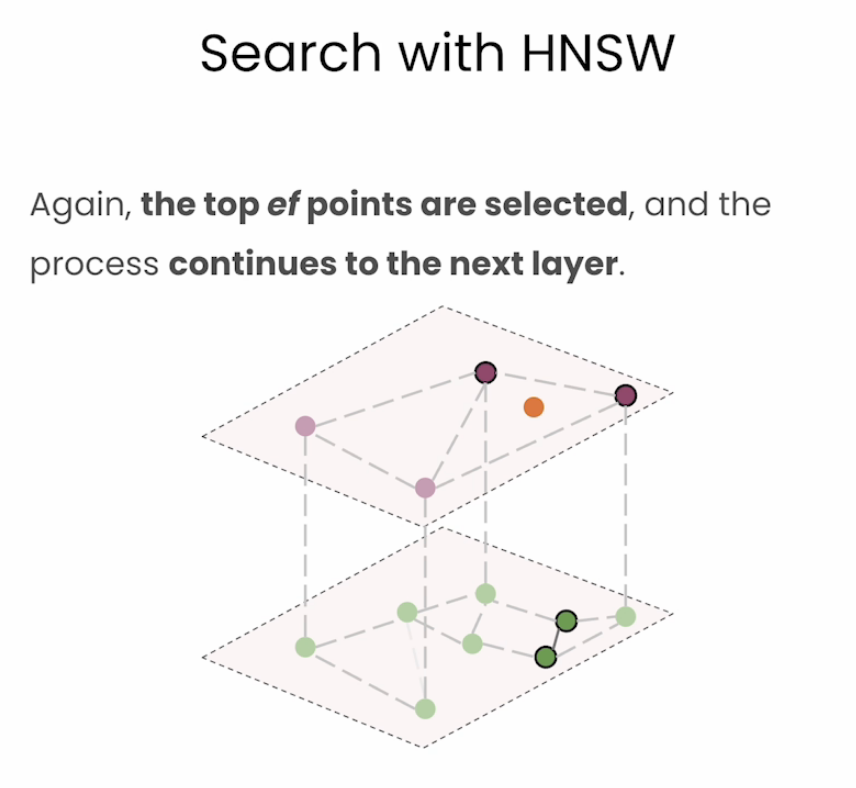
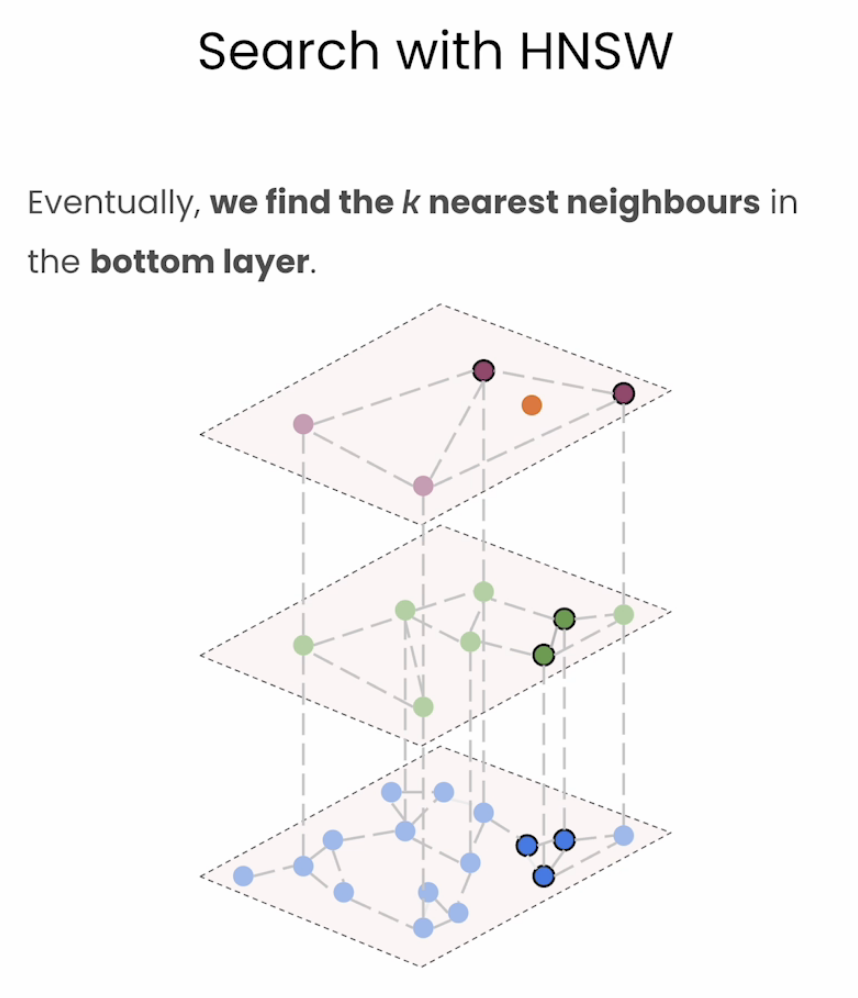
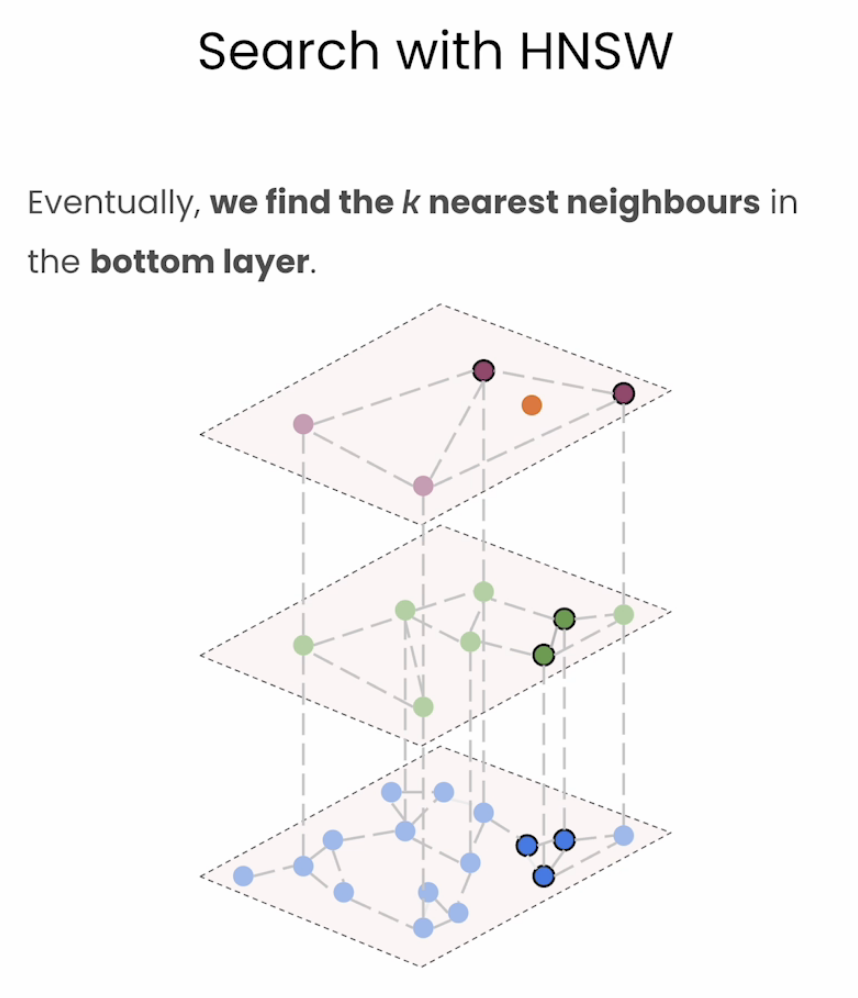

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from qdrant_client import QdrantClient, models

client = QdrantClient("http://localhost:6333", timeout=600)
collection = client.get_collection("wands-products")
collection

CollectionInfo(status=<CollectionStatus.GREEN: 'green'>, optimizer_status=<OptimizersStatusOneOf.OK: 'ok'>, vectors_count=None, indexed_vectors_count=8960, points_count=5000, segments_count=2, config=CollectionConfig(params=CollectionParams(vectors={'product_description': VectorParams(size=384, distance=<Distance.COSINE: 'Cosine'>, hnsw_config=None, quantization_config=None, on_disk=None, datatype=None, multivector_config=None), 'product_name': VectorParams(size=384, distance=<Distance.COSINE: 'Cosine'>, hnsw_config=None, quantization_config=None, on_disk=None, datatype=None, multivector_config=None)}, shard_number=1, sharding_method=None, replication_factor=1, write_consistency_factor=1, read_fan_out_factor=None, on_disk_payload=True, sparse_vectors=None), hnsw_config=HnswConfig(m=16, ef_construct=100, full_scan_threshold=10000, max_indexing_threads=0, on_disk=False, payload_m=None), optimizer_config=OptimizersConfig(deleted_threshold=0.2, vacuum_min_vector_number=1000, default_segmen

# HNSW parameters

In [3]:
collection.config.hnsw_config

HnswConfig(m=16, ef_construct=100, full_scan_threshold=10000, max_indexing_threads=0, on_disk=False, payload_m=None)

# Test queries

In [4]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("all-MiniLM-L6-v2")

In [6]:
import pandas as pd

queries_df = pd.read_csv(
    "https://github.com/wayfair/WANDS/raw/refs/heads/main/dataset/query.csv", 
    sep="\t", 
    index_col="query_id",
)
queries_df["query_embedding"] = model.encode(
    queries_df["query"].tolist()
).tolist()
queries_df.sample(n=5)

query        query_class  \
query_id                                                          
45                    70s inspired furniture           Wall Art   
280             johan desk by laurel foundry              Desks   
15        black 5 drawer dresser by guilford  Dressers & Chests   
442                     above toilet cabinet   Bathroom Storage   
441                            desk for kids         Kids Desks   

                                            query_embedding  
query_id                                                     
45        [0.017743267118930817, 0.05385656654834747, -0...  
280       [-0.06518600136041641, 0.11351057887077332, -0...  
15        [-0.08426313102245331, 0.039035674184560776, -...  
442       [0.07138674706220627, -0.005079863127321005, -...  
441       [-0.04550235718488693, 0.060317445546388626, 0...

# ANN search

In [7]:
client.search(
    "wands-products",
    query_vector=models.NamedVector(
        name="product_name",
        vector=model.encode(queries_df.loc[0, "query"])
    ),
    limit=3,
    with_vectors=False,
    with_payload=False,
)

[ScoredPoint(id=4410, version=68, score=0.7512182, payload=None, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id=4034, version=63, score=0.744174, payload=None, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id=251, version=3, score=0.7269763, payload=None, vector=None, shard_key=None, order_value=None)]

# kNN search

In [8]:
client.search(
    "wands-products",
    query_vector=models.NamedVector(
        name="product_name",
        vector=model.encode(queries_df.loc[0, "query"])
    ),
    limit=3,
    with_vectors=False,
    with_payload=False,
    search_params=models.SearchParams(
        exact=True,  # Turns on the exact search mode
    ),
)

[ScoredPoint(id=4410, version=68, score=0.7512182, payload=None, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id=4034, version=63, score=0.744174, payload=None, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id=251, version=3, score=0.7269763, payload=None, vector=None, shard_key=None, order_value=None)]

# Ground truth

In [9]:
from collections import defaultdict
from ranx import Qrels

knn_qrels_dict = defaultdict(dict)
for id, row in queries_df.iterrows():
    query_id = f"query_{id}"
    
    results = client.search(
        collection_name="wands-products",
        query_vector=models.NamedVector(
            name="product_name", 
            vector=row["query_embedding"]
        ),
        with_vectors=False,
        with_payload=False,
        limit=100,
        search_params=models.SearchParams(
            exact=True,  # enable exact search
        ),
    )
    
    for point in results:
        document_id = f"doc_{point.id}"
        # The conversion to integer is required because ranx expects integers
        knn_qrels_dict[query_id][document_id] = int(point.score * 100)
    
qrels = Qrels(knn_qrels_dict)
qrels

DictType[unicode_type,DictType[[unichr x 8],int64]<iv=None>]<iv=None>({query_0: {doc_4410: 75, doc_4034: 74, doc_251: 72, doc_2187: 72, doc_975: 69, doc_1616: 65, doc_4444: 65, doc_746: 64, doc_209: 64, doc_2638: 64, doc_308: 63, doc_1372: 63, doc_1148: 63, doc_1059: 63, doc_603: 62, doc_1742: 61, doc_4938: 61, doc_4330: 60, doc_1259: 60, doc_1864: 60, doc_4329: 59, doc_1373: 59, doc_1454: 59, doc_3604: 59, doc_4046: 58, doc_3880: 58, doc_2813: 58, doc_4709: 58, doc_206: 58, doc_187: 58, doc_703: 57, doc_2321: 57, doc_1149: 57, doc_2584: 57, doc_4044: 57, doc_2245: 57, doc_445: 57, doc_4367: 57, doc_489: 57, doc_1771: 56, doc_4013: 56, doc_585: 56, doc_2565: 56, doc_1681: 56, doc_701: 56, doc_4050: 56, doc_2729: 56, doc_1786: 56, doc_1566: 55, doc_2883: 55, doc_1240: 55, doc_2935: 55, doc_3164: 55, doc_4956: 55, doc_369: 55, doc_4854: 55, doc_580: 55, doc_702: 55, doc_2867: 55, doc_2868: 55, doc_1817: 55, doc_451: 55, doc_2604: 55, doc_359: 55, doc_4708: 55, doc_1275: 54, doc_4043: 54,

# ANN search

In [10]:
from ranx import Run

run_dict = defaultdict(dict)
for id, row in queries_df.iterrows():
    query_id = f"query_{id}"
    
    results = client.search(
        collection_name="wands-products",
        query_vector=models.NamedVector(
            name="product_name", 
            vector=row["query_embedding"]
        ),
        with_vectors=False,
        with_payload=False,
        limit=100,
        search_params=models.SearchParams(
            exact=False,  # disable exact search
        ),
    )
    
    for point in results:
        document_id = f"doc_{point.id}"
        run_dict[query_id][document_id] = point.score

initial_run = Run(
    run_dict, 
    name="initial",
)
initial_run

DictType[unicode_type,DictType[[unichr x 8],float64]<iv=None>]<iv=None>({query_0: {doc_4410: 0.7512183, doc_4034: 0.744174, doc_251: 0.7269764, doc_2187: 0.72043705, doc_975: 0.69298476, doc_1616: 0.65913177, doc_4444: 0.6508612, doc_746: 0.648947, doc_209: 0.64784795, doc_2638: 0.6400894, doc_1148: 0.63802826, doc_1059: 0.6332265, doc_1372: 0.63219, doc_308: 0.63199496, doc_603: 0.62417847, doc_1742: 0.6134179, doc_4938: 0.6115167, doc_4330: 0.60891736, doc_1259: 0.6060815, doc_1864: 0.6024618, doc_4329: 0.59796256, doc_1373: 0.5947803, doc_1454: 0.5935928, doc_3604: 0.5926492, doc_187: 0.58951074, doc_206: 0.5892327, doc_4709: 0.58808076, doc_2813: 0.58612514, doc_4046: 0.58583736, doc_3880: 0.58472776, doc_489: 0.57867414, doc_4367: 0.57795393, doc_445: 0.57703555, doc_2245: 0.5748277, doc_4044: 0.5732144, doc_2584: 0.57205856, doc_1149: 0.5718453, doc_2321: 0.57073593, doc_703: 0.5707159, doc_2729: 0.56709486, doc_4050: 0.5650703, doc_1681: 0.56440973, doc_701: 0.56390893, doc_1786

In [11]:
from ranx import evaluate

evaluate(
    qrels=qrels, 
    run=initial_run, 
    metrics=["precision@25"]
)

1.0

# Tweaking the HNSW parameters

In [12]:
client.update_collection(
    collection_name="wands-products",
    hnsw_config=models.HnswConfigDiff(
        m=64, 
        ef_construct=200,
    )
)

True

In [13]:
import time

time.sleep(1.0)
collection = client.get_collection("wands-products")
while collection.status != models.CollectionStatus.GREEN:
    time.sleep(1.0)
    collection = client.get_collection("wands-products")
    
collection

CollectionInfo(status=<CollectionStatus.GREEN: 'green'>, optimizer_status=<OptimizersStatusOneOf.OK: 'ok'>, vectors_count=None, indexed_vectors_count=8960, points_count=5000, segments_count=2, config=CollectionConfig(params=CollectionParams(vectors={'product_description': VectorParams(size=384, distance=<Distance.COSINE: 'Cosine'>, hnsw_config=None, quantization_config=None, on_disk=None, datatype=None, multivector_config=None), 'product_name': VectorParams(size=384, distance=<Distance.COSINE: 'Cosine'>, hnsw_config=None, quantization_config=None, on_disk=None, datatype=None, multivector_config=None)}, shard_number=1, sharding_method=None, replication_factor=1, write_consistency_factor=1, read_fan_out_factor=None, on_disk_payload=True, sparse_vectors=None), hnsw_config=HnswConfig(m=64, ef_construct=200, full_scan_threshold=10000, max_indexing_threads=0, on_disk=False, payload_m=None), optimizer_config=OptimizersConfig(deleted_threshold=0.2, vacuum_min_vector_number=1000, default_segmen

In [14]:
tweaked_run_dict = defaultdict(dict)
for id, row in queries_df.iterrows():
    query_id = f"query_{id}"
    
    results = client.search(
        collection_name="wands-products",
        query_vector=models.NamedVector(
            name="product_name", 
            vector=row["query_embedding"]
        ),
        with_vectors=False,
        with_payload=False,
        limit=100,
        search_params=models.SearchParams(
            exact=False,  # disable exact search
        ),
    )
    
    for point in results:
        document_id = f"doc_{point.id}"
        tweaked_run_dict[query_id][document_id] = point.score
    
tweaked_run = Run(
    tweaked_run_dict, 
    name="tweaked"
)
tweaked_run

DictType[unicode_type,DictType[[unichr x 8],float64]<iv=None>]<iv=None>({query_0: {doc_4410: 0.7512183, doc_4034: 0.744174, doc_251: 0.7269764, doc_2187: 0.72043705, doc_975: 0.69298476, doc_1616: 0.65913177, doc_4444: 0.6508612, doc_746: 0.648947, doc_209: 0.64784795, doc_2638: 0.6400894, doc_1148: 0.63802826, doc_1059: 0.6332265, doc_1372: 0.63219, doc_308: 0.63199496, doc_603: 0.62417847, doc_1742: 0.6134179, doc_4938: 0.6115167, doc_4330: 0.60891736, doc_1259: 0.6060815, doc_1864: 0.6024618, doc_4329: 0.59796256, doc_1373: 0.5947803, doc_1454: 0.5935928, doc_3604: 0.5926492, doc_187: 0.58951074, doc_206: 0.5892327, doc_4709: 0.58808076, doc_2813: 0.58612514, doc_4046: 0.58583736, doc_3880: 0.58472776, doc_489: 0.57867414, doc_4367: 0.57795393, doc_445: 0.57703555, doc_2245: 0.5748277, doc_4044: 0.5732144, doc_2584: 0.57205856, doc_1149: 0.5718453, doc_2321: 0.57073593, doc_703: 0.5707159, doc_2729: 0.56709486, doc_4050: 0.5650703, doc_1681: 0.56440973, doc_701: 0.56390893, doc_1786

In [15]:
evaluate(
    qrels=qrels, 
    run=tweaked_run, 
    metrics=["precision@25"]
)

1.0

# In most systems hnsw are segments - aka. partitions of the data
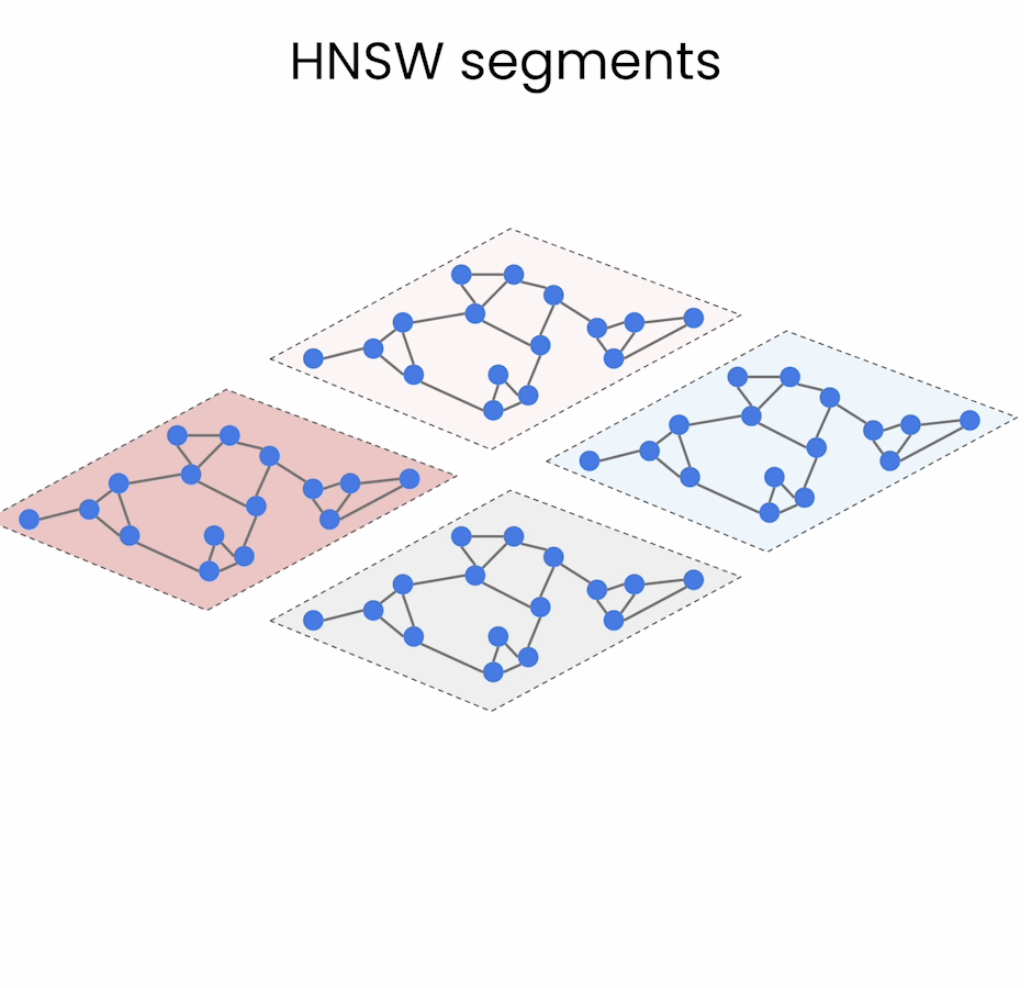